### Import packages


In [98]:
from pathlib import Path
import logging

import pandas as pd
import numpy as np
from scipy.optimize import fsolve
from numpy.random import rand,choice
import matplotlib.pyplot as plt

### Const set


In [4]:
PATH_FIGURE_ROOT = Path("../figure")
ZERO = 1e-8

### Data reference


In [5]:
planes = ["FY00","FY01","FY02","FY03","FY04","FY05","FY06","FY07","FY08","FY09"]

radius = 10
arches = 0

divide_arch = 2*40*np.pi/360


plane_positions = [(radius*np.cos(alpha),radius*np.sin(alpha)) for alpha in np.arange(0,2*np.pi,divide_arch)]
plane_positions.insert(0,(np.float64(0),np.float64(0)))

plane_positions_truth = [(i[0]+rand()-0.5,i[1]+rand()-0.5) for i in plane_positions[3:]]

cxs = [radius*np.cos(alpha) for alpha in np.arange(0,2*np.pi+0.1,0.1)]
cys = [radius*np.sin(alpha) for alpha in np.arange(0,2*np.pi+0.1,0.1)]


### Calculate


In [6]:
def get_degree_arc(alpha):
    return alpha*2*np.pi/360

def get_degree_angle(alpha):
    return alpha*360/(2*np.pi)

In [7]:
def is_equal(a:np.float64,b:np.float64)->np.bool:
    return np.abs(a-b) < 1e-7

In [8]:
def r2xy(r,theta):
    return r*np.cos(theta),r*np.sin(theta)

def xy2r(x,y):
    return np.sqrt(x**2,y**2),np.arctan(y/x)

In [9]:
def make_line(p1,p2):
    k = np.float64(p2[1]-p1[1])/np.float64(p2[0]-p1[0])
    vk = -1/k
    b = p1[1] - p1[0]*k
    vb = (p2[1]+p1[1])/2 - vk*(p2[0]+p1[0])/2
    alpha = np.arctan(k)
    return k,b,vk,vb,alpha

In [10]:
def get_line_length(p1,p2):
    return np.sqrt((p2[0]-p1[0])**2+(p2[1]-p1[1])**2)

$$P \times M + D = P' $$

$$
\begin{bmatrix}
x \\
y
\end{bmatrix}
\times
\begin{bmatrix}
\cos{\theta} & \sin{\theta} \\
-\sin{\theta} & \cos{\theta}
\end{bmatrix}
+
\begin{bmatrix}
x_{diff} \\
y_{diff}
\end{bmatrix}
=
\begin{bmatrix}
x'\\
y'
\end{bmatrix}
$$


In [11]:
def routate(p:np.ndarray,alpha):
    return np.dot(p,np.array([[np.cos(alpha),np.sin(alpha)],[-np.sin(alpha),np.cos(alpha)]]))

In [205]:
def get_center(p1,p2,theta):
    upset,p1,p2 = (False,p1,p2 )if p1[0] <= p2[0] else (True,p2,p1)
    k,b,vk,vb,alpha = make_line(p1,p2)
    
    l = get_line_length(p1,p2)
    radius = l/(2*np.sin(theta))
    
    center_origin_p = np.array([0,radius*np.cos(theta)])
    center_origin_n = np.array([0,-radius*np.cos(theta)])
    
    p2_origin = np.array([l/2,0])
    
    # if p1[0] <= p2[0]:
    #     p_diff = p2 - routate(p2_origin,alpha)
    # else:
    p_diff = p2 - routate(p2_origin,alpha)
        
    
    center_p = routate(center_origin_p,alpha)+p_diff
    center_n = routate(center_origin_n,alpha)+p_diff
    
    if not upset:
        return center_p,center_n,radius
    else:
        return center_n,center_p,radius

In [39]:
def get_angle(p1,p2,p):
    a = get_line_length(p1,p)
    b = get_line_length(p2,p)
    c = get_line_length(p1,p2)
    return np.arccos((a**2+b**2-c**2)/(2*a*b))

In [171]:
def location(ps,p):
    alpha_1 = get_angle(ps[0],ps[1],p)
    alpha_2 = get_angle(ps[0],ps[2],p)
    alpha_3 = get_angle(ps[2],ps[1],p)
    return alpha_1,alpha_2,alpha_3

In [88]:
get_degree_angle(get_angle((0,1),(1,1),(0,0)))

np.float64(44.999999999999986)

In [93]:
get_center((0,0),(1,11),get_degree_arc(get_degree_angle(get_angle((0,1),(1,11),(0,0)))))

(array([-60.,  11.]),
 array([ 6.10000000e+01, -3.86357613e-13]),
 np.float64(61.00000000000419))

In [94]:
get_center((1,2),(4,11),get_angle((1,2),(4,11),(1,6)))

(array([10.,  4.]), array([-5.,  9.]), np.float64(9.219544457292887))

In [41]:
def equation_1(phi,alpha,beta,theta):
    return np.sin(alpha)*np.sin(np.pi-phi-beta)-np.sin(beta)*np.sin(np.pi-alpha-theta+phi)

In [106]:
# get_center((3,5),(6,9),0.836448659158)
get_degree_angle(fsolve(equation_1,get_degree_arc(10),(get_degree_arc(40),get_degree_arc(40),get_degree_arc(70))))

array([35.])

In [113]:
a = (location([(-np.sqrt(2),np.sqrt(2)),(np.sqrt(2),np.sqrt(2)),(0,2)],(0,0)))

In [120]:
get_center((-np.sqrt(2),np.sqrt(2)),(np.sqrt(2),np.sqrt(2)),np.pi/2)

/tmp/ipykernel_2361/1433859345.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  vk = -1/k
/tmp/ipykernel_2361/1433859345.py:5: RuntimeWarning: invalid value encountered in scalar multiply
  vb = (p2[1]+p1[1])/2 - vk*(p2[0]+p1[0])/2


(array([0.        , 1.41421356]),
 array([0.        , 1.41421356]),
 np.float64(1.4142135623730951))

In [124]:
get_center((0,2),(-np.sqrt(2),np.sqrt(2)),np.pi/4)

(array([-1.        ,  2.41421356]),
 array([-0.41421356,  1.        ]),
 np.float64(1.0823922002923942))

### Draw


In [43]:
def plot_line(base_point,other_points):
    for p in other_points:
        plt.plot([base_point[0],p[0]],[base_point[1],p[1]])

In [44]:
def circle(center, radius,color:str):
    xs = [(radius * np.cos(theta) + center[0]) for theta in np.arange(0, 2 * np.pi, 0.01)]
    ys = [(radius * np.sin(theta) + center[1]) for theta in np.arange(0, 2 * np.pi, 0.01)]
    plt.plot(xs,ys,color=color)

### Test


$$
P_{tr} \to P_{ex}
$$

In [60]:
get_angle((3,0),(0,4),(0,0))

np.float64(1.5707963267948966)

In [61]:
# plane_positions

In [62]:
radius = 10

plane_series_tag = [1,2,3,4,5,6,7,8,9]

plane_series = np.array([(np.float64(ZERO),np.float64(ZERO)),*[(radius,x) for x in np.arange(ZERO,2*np.pi,40*2*np.pi/360)]])

plane_main_tag = [0,*[tag.item() for tag in choice(plane_series_tag,size=2,replace=False)]]

plane_main_tag.sort()

plane_main = [plane_series[plane_tag] for plane_tag in plane_main_tag]

plane_1 = plane_series[9] + [rand(),rand()]

<!-- 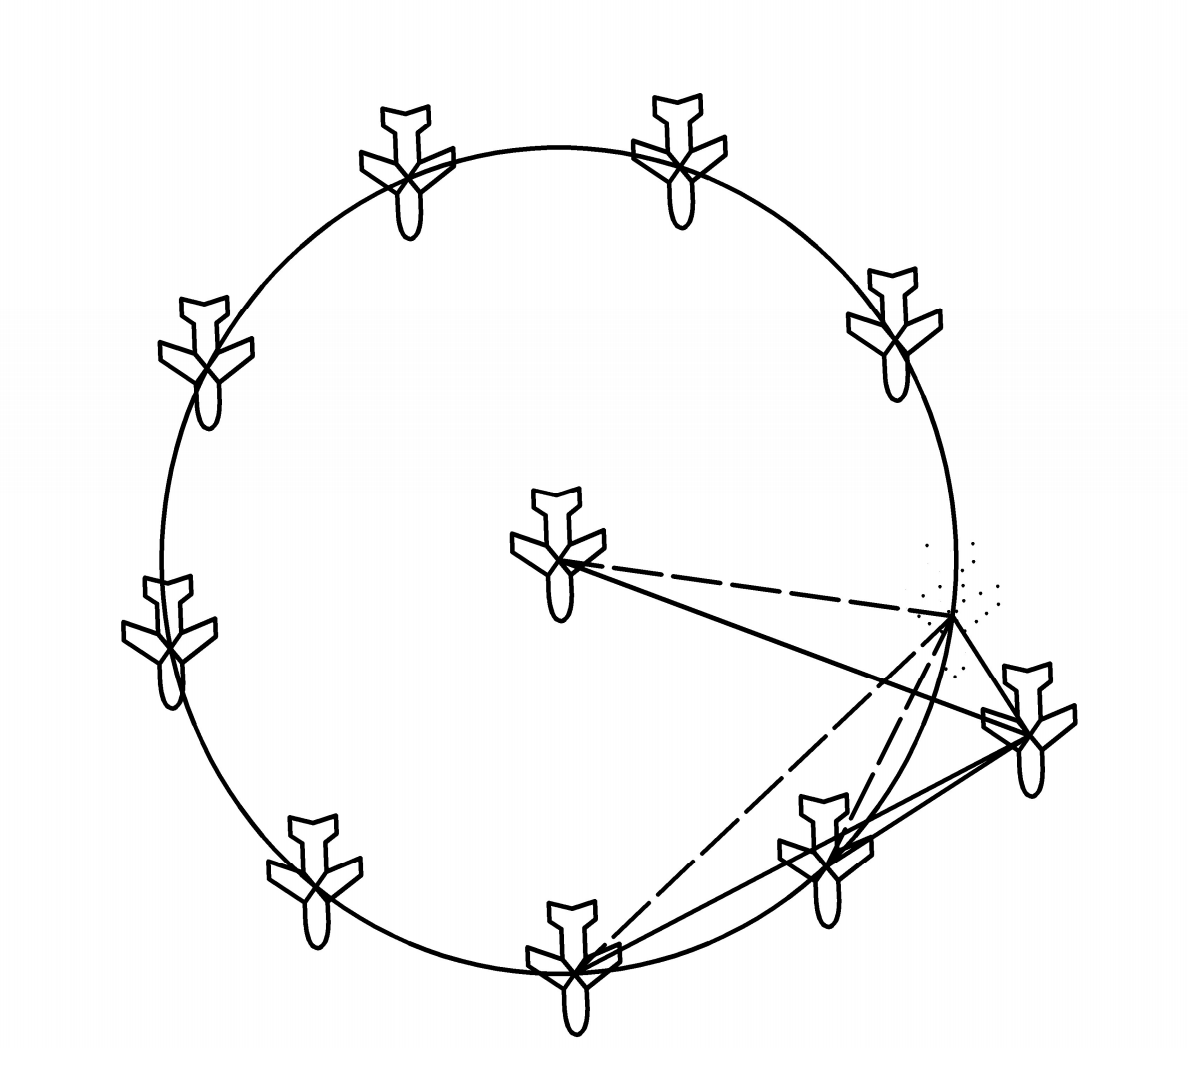 -->


In [63]:
plane_series
plane_series_xy = [r2xy(*p)for p in plane_series]

In [207]:
# plane_series_xy

In [206]:
# plane_positions

In [208]:
# plt.figure(figsize=(8,8))
# circle((0,0),10,"#F0F")
# plt.scatter([x[0] for x in plane_series_xy],[x[1] for x in plane_series_xy])



# plt.show()


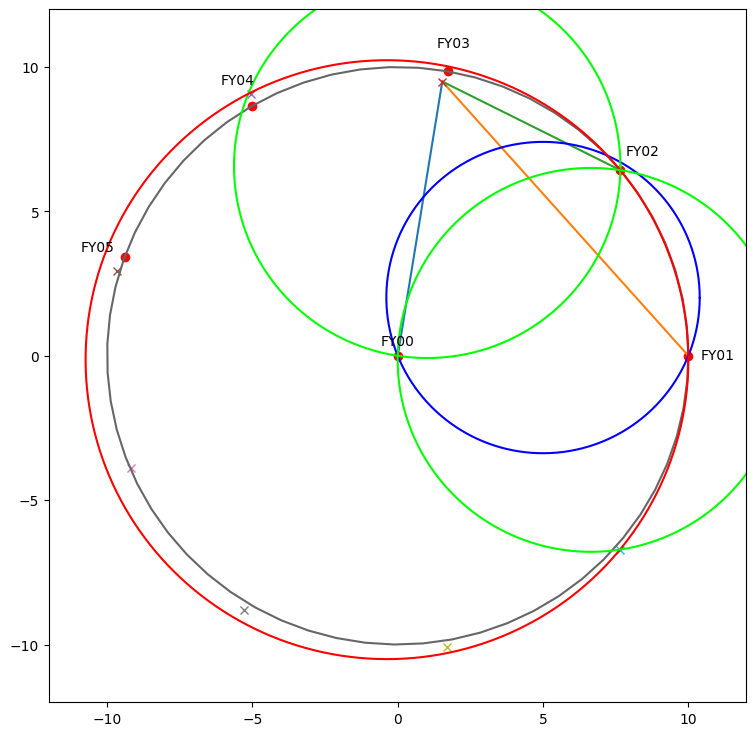

In [222]:
plt.figure(figsize=(9,9))
for i, (x, y) in enumerate(plane_series_xy[:6]):
    if i != 0:
        plt.plot(x, y, "ro")  # 蓝色圆点
        plt.text(
            x * 1.1, y * 1.1, planes[i], fontsize=10, ha="center", va="center"
        )  # 标签略外移
    else:
        plt.plot(x, y, "ro")  # 蓝色圆点
        plt.text(
            x, y + 0.5, planes[i], fontsize=10, ha="center", va="center"
        )  # 标签略外移
        
# for i,(x,y) in enumerate(plane_positions[1:4]):
#     plt.plot([0,x],[0,y])
plot_line(plane_positions_truth[0],plane_positions[:3])



for i, (x, y) in enumerate(plane_positions_truth):
    plt.plot(x,y,"x")
plt.xlim([-12,12])
plt.ylim([-12,12])
plt.plot(cxs, cys, color="#666666")

ls = location(plane_series_xy[0:3],plane_positions_truth[6])

c1_1,c2_1,r_1 = get_center(plane_series_xy[0],plane_series_xy[1],ls[0])
c1_2,c2_2,r_2 = get_center(plane_series_xy[0],plane_series_xy[2],ls[1])
c1_3,c2_3,r_3 = get_center(plane_series_xy[1],plane_series_xy[2],ls[2])

# c1,c2,r = get_center(plane_main[0],,(np.pi*4/9))
# c1_2,c2_2,r_2 = get_center(plane_positions[0],plane_positions[2],np.pi*4/9)
# c1_3,c2_3,r_3 = get_center(plane_positions[1],plane_positions[2],np.pi*8/9)
 
# print(c1,c2,r)
# print(c1_2,c2_2,r_3)
# print(c1_3,c2_3,r_3)
circle(c1_1,r_1,color="#0000FF")
circle(c1_2,r_2,color="#00FF00")
circle(c1_3,r_3,color="#FF0000")
# circle(c2_1,r_1,color="#0000FF")
circle(c2_2,r_2,color="#00FF00")
# circle(c2_3,r_3,color="#FF0000")

# circle((3,3),5,"#0Ff0FF")
# plt.scatter(xs,ys,marker="x")
plt.show()

In [68]:
plane_main,plane_main_tag,plane_1

([array([1.e-08, 1.e-08]),
  array([10.        ,  2.79252681]),
  array([10.        ,  4.18879021])],
 [0, 5, 7],
 array([10.74272103,  5.61030124]))

In [69]:
a = np.array(location(plane_main,plane_1))

In [70]:
a.sort()
a

array([0.22375251, 0.60803882, 0.83179133])

In [71]:
is_equal(a[1]+a[0] , a[2])

np.True_

In [72]:
routate([1,1],np.pi*3/2)

array([ 1., -1.])

In [73]:
get_center((-1,0),(1,0),np.pi*90*2/360)

/tmp/ipykernel_2361/1433859345.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  vk = -1/k
/tmp/ipykernel_2361/1433859345.py:5: RuntimeWarning: invalid value encountered in scalar multiply
  vb = (p2[1]+p1[1])/2 - vk*(p2[0]+p1[0])/2


(array([-2.000000e+00,  6.123234e-17]),
 array([-2.000000e+00, -6.123234e-17]),
 np.float64(1.0))